# PC Session 3

**Author:**
[Helge Liebert](https://hliebert.github.io/)

# **Text analysis**: Kiva loans

## Dependencies

In [1]:
## Libraries
library(tm)
library(data.table)
library(ggplot2)
library(tidytext)
library(dplyr)
library(topicmodels)
library(wordcloud)
library(SentimentAnalysis)
library(naivebayes)
library(slam)
library(glmnet)
library(lexicon)
library(fastNaiveBayes)
library(caret)

Loading required package: NLP

Warning message:
"replacing previous import 'vctrs::data_frame' by 'tibble::data_frame' when loading 'dplyr'"

Attaching package: 'ggplot2'


The following object is masked from 'package:NLP':

    annotate



Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: RColorBrewer


Attaching package: 'SentimentAnalysis'


The following object is masked from 'package:base':

    write


naivebayes 0.9.7 loaded


Attaching package: 'naivebayes'


The following object is masked from 'package:data.table':

    tables



Attaching package: 'slam'


The following object is masked from 'package:data.table':

    rollup


Loading required package: Matrix

Loaded glmnet 4.0-2

Loading required package: lattice



In [2]:
## Simple helper function to view first copora elements, only for illustration in lecture
chead <- function(c) lapply(c[1:2], as.character)

## Setting up a corpus and applying transformations

This tutorial relies on the Kiva data from the last lecture. The text analyses are based on the loan description and to a limited extent the loan purpose statement as well. The data is based on a csv database dump provided on their site. To ease computation we just use a limited sample of 10,000 observations. Using the csv file from the Kiva Homepage and the file `prep-kiva.r`, you can clean the data yourself and use a larger sample. The full sample is close to one million observations. (You might need to delete a few nested parentheses in the loan description using a text editor which lead to errors reading the csv file.) If you look at the script, you can also see that I spent some time pre-processing the data, filtering HTML tags and similar things, to get mostly clean loan descriptions. This type of pre-processing is common, but also very application specific.

In case you are using Windows, or any other OS not using UTF-8 encoding as default, setting the encoding when reading data files is good practice. When working with text data, take care to ensure you are using the correct encoding and that transformations between files and encodings do not lead to broken characters.

In [3]:
## Read data
loans <- fread("Data/kiva-tiny.csv", encoding = "UTF-8")
names(loans)

[1] "loanid"            "description"       "fundedamount"     
[4] "loanamount"        "activityname"      "sectorname"       
[7] "loanuse"           "countryname"       "repaymentinterval"

The first thing we are going to do is set up a corpus. We will focus on the loan description. For all transformations in the remainder of this tutorial, we are going to print the first two loans' descriptions for illustration.

In [4]:
## Set up corpus
setnames(loans, "loanid", "doc_id")
setnames(loans, "description", "text")
corp <- Corpus(DataframeSource(loans))

## Inspect it
corp
lapply(corp[1:2], as.character)

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 7
Content:  documents: 10000

$`269894`
[1] "Esteban belongs to the “Las Margarita Ocongate” community bank and lives in the city of Ocongate, in Quispicanchis province, in Cusco department, Peru. He lives with his wife and his 5 year-old daughter Crisanta. The city of Ocongate is two hours from the city of Cusco. Esteban studied law at the National University of San Antonio Abad in Cusco but he was unable to complete his degree for financial reasons. He decided to start a new life. Esteban worked helping lawyers write documentation and then trained to become a legal counselor (someone who provides advice on legal matters including criminal issues, civil issues, labor issues, contracts, transfers, fees, and other cases). After working in different cities in Cusco department as a legal counselor, Esteban decided to set up in the city of Ocongate and opened a legal counseling office. Esteban requires this loan to buy stationery supplies such as paper, pens and many other products. Esteban is grateful for this opportunity and he pledges to make his repayments on time."

$`1247640`
[1] "Kosar is a married woman and entrepreneur and a new borrower through BRAC Pakistan. She has worked hard day-and-night to manage the household expenses. Kosar recently opened a salon and needs to decorate the interior and buy stock of cosmetics and beauty-related electronics. Kosar has requested for a loan from BRAC Pakistan to help establish her salon business by fixing up the interior, for which she needs to buy salon chairs and cosmetics to attract more customers. This is Kosar’s first loan, and she is very happy to have support from BRAC Pakistan and Kiva."

These are the main transformations available in the `tm` library, but any other customized transformation can be applied.

In [5]:
## Main corpus transformations, passed via tm_map()
## Other transformations have to be wrapped in content_transformer()
getTransformations()

[1] "removeNumbers"     "removePunctuation" "removeWords"      
[4] "stemDocument"      "stripWhitespace"

We apply the `base` string function `tolower()` to transform all strings to lower case.

In [6]:
## All chars to lower case
corp <- tm_map(corp, content_transformer(tolower))
chead(corp)

$`269894`
[1] "esteban belongs to the “las margarita ocongate” community bank and lives in the city of ocongate, in quispicanchis province, in cusco department, peru. he lives with his wife and his 5 year-old daughter crisanta. the city of ocongate is two hours from the city of cusco. esteban studied law at the national university of san antonio abad in cusco but he was unable to complete his degree for financial reasons. he decided to start a new life. esteban worked helping lawyers write documentation and then trained to become a legal counselor (someone who provides advice on legal matters including criminal issues, civil issues, labor issues, contracts, transfers, fees, and other cases). after working in different cities in cusco department as a legal counselor, esteban decided to set up in the city of ocongate and opened a legal counseling office. esteban requires this loan to buy stationery supplies such as paper, pens and many other products. esteban is grateful for this opportunity and he pledges to make his repayments on time."

$`1247640`
[1] "kosar is a married woman and entrepreneur and a new borrower through brac pakistan. she has worked hard day-and-night to manage the household expenses. kosar recently opened a salon and needs to decorate the interior and buy stock of cosmetics and beauty-related electronics. kosar has requested for a loan from brac pakistan to help establish her salon business by fixing up the interior, for which she needs to buy salon chairs and cosmetics to attract more customers. this is kosar’s first loan, and she is very happy to have support from brac pakistan and kiva."

Remove all punctuation as punctuation is unlikely to carry special meaning in the context of loans and we want to simplify the text input to get token counts. We need to set the unicode option to true to rid of all punctuation elements (eg. the quotation marks).

In [7]:
## Remove punctuation
corp <- tm_map(corp, removePunctuation)
chead(corp)
## corp <- tm_map(corp, removePunctuation, ucp = TRUE)
## chead(corp)

$`269894`
[1] "esteban belongs to the “las margarita ocongate” community bank and lives in the city of ocongate in quispicanchis province in cusco department peru he lives with his wife and his 5 yearold daughter crisanta the city of ocongate is two hours from the city of cusco esteban studied law at the national university of san antonio abad in cusco but he was unable to complete his degree for financial reasons he decided to start a new life esteban worked helping lawyers write documentation and then trained to become a legal counselor someone who provides advice on legal matters including criminal issues civil issues labor issues contracts transfers fees and other cases after working in different cities in cusco department as a legal counselor esteban decided to set up in the city of ocongate and opened a legal counseling office esteban requires this loan to buy stationery supplies such as paper pens and many other products esteban is grateful for this opportunity and he pledges to make his repayments on time"

$`1247640`
[1] "kosar is a married woman and entrepreneur and a new borrower through brac pakistan she has worked hard dayandnight to manage the household expenses kosar recently opened a salon and needs to decorate the interior and buy stock of cosmetics and beautyrelated electronics kosar has requested for a loan from brac pakistan to help establish her salon business by fixing up the interior for which she needs to buy salon chairs and cosmetics to attract more customers this is kosar’s first loan and she is very happy to have support from brac pakistan and kiva"

Now we remove all numbers. We observe the loan amount and the repayment schedule in other variables, so we can get rid of numbers. Extracting the meaning of numbers within their context is difficult. 

In [8]:
## Remove numbers
corp <- tm_map(corp, removeNumbers)
chead(corp)

$`269894`
[1] "esteban belongs to the “las margarita ocongate” community bank and lives in the city of ocongate in quispicanchis province in cusco department peru he lives with his wife and his  yearold daughter crisanta the city of ocongate is two hours from the city of cusco esteban studied law at the national university of san antonio abad in cusco but he was unable to complete his degree for financial reasons he decided to start a new life esteban worked helping lawyers write documentation and then trained to become a legal counselor someone who provides advice on legal matters including criminal issues civil issues labor issues contracts transfers fees and other cases after working in different cities in cusco department as a legal counselor esteban decided to set up in the city of ocongate and opened a legal counseling office esteban requires this loan to buy stationery supplies such as paper pens and many other products esteban is grateful for this opportunity and he pledges to make his repayments on time"

$`1247640`
[1] "kosar is a married woman and entrepreneur and a new borrower through brac pakistan she has worked hard dayandnight to manage the household expenses kosar recently opened a salon and needs to decorate the interior and buy stock of cosmetics and beautyrelated electronics kosar has requested for a loan from brac pakistan to help establish her salon business by fixing up the interior for which she needs to buy salon chairs and cosmetics to attract more customers this is kosar’s first loan and she is very happy to have support from brac pakistan and kiva"

Any other transformation - like substituting specific patterns based on regular expressions - can be passed to `tm_map()` using a user-defined function.

In [9]:
## For specific transformations, you could also pass a lambda function to remove patterns based on a regex

## Example:
## toSpace <- content_transformer(function (x , pattern) gsub(pattern, " ", x))
## corp <- tm_map(corp, toSpace, "patternhere")

Looking at a frequency plot of the token counts, there is still plenty of filtering to do to get meaningful token counts.

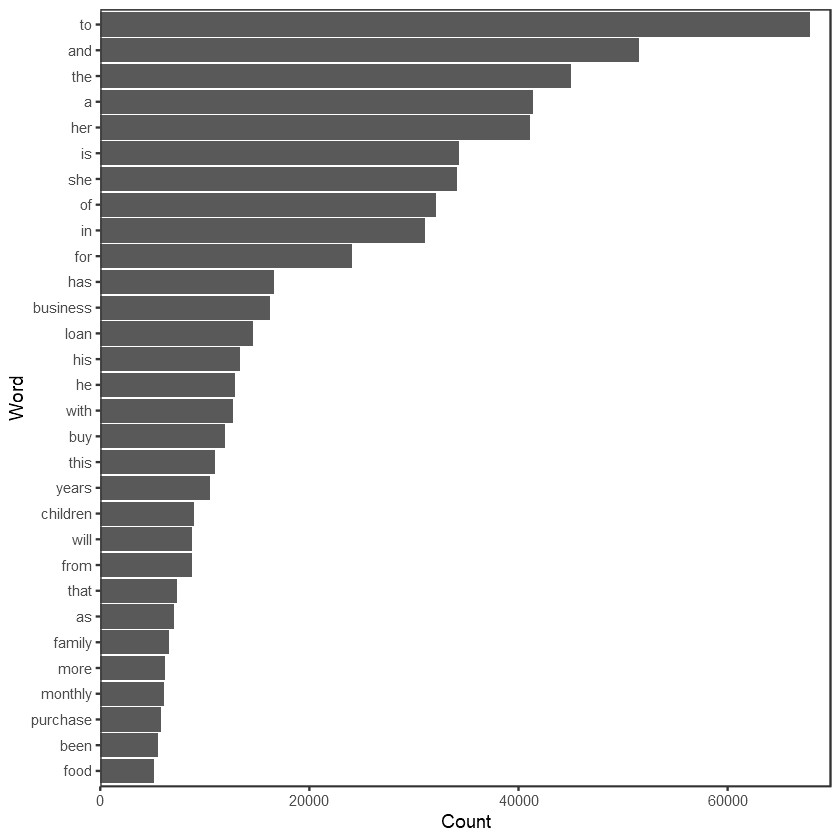

In [10]:
## Look at the most frequent words in our text and see whether we should get rid of some
frequent_terms <- qdap::freq_terms(corp, 30)
plot(frequent_terms)

Next, we remove stopwords and other generic words which do not carry special meaning in our context.

In [11]:
## More invasive changes: remove generic and custom stopwords
corp <- tm_map(corp, removeWords, stopwords('english'))
chead(corp)

$`269894`
[1] "esteban belongs   “las margarita ocongate” community bank  lives   city  ocongate  quispicanchis province  cusco department peru  lives   wife    yearold daughter crisanta  city  ocongate  two hours   city  cusco esteban studied law   national university  san antonio abad  cusco    unable  complete  degree  financial reasons  decided  start  new life esteban worked helping lawyers write documentation   trained  become  legal counselor someone  provides advice  legal matters including criminal issues civil issues labor issues contracts transfers fees   cases  working  different cities  cusco department   legal counselor esteban decided  set    city  ocongate  opened  legal counseling office esteban requires  loan  buy stationery supplies   paper pens  many  products esteban  grateful   opportunity   pledges  make  repayments  time"

$`1247640`
[1] "kosar   married woman  entrepreneur   new borrower  brac pakistan   worked hard dayandnight  manage  household expenses kosar recently opened  salon  needs  decorate  interior  buy stock  cosmetics  beautyrelated electronics kosar  requested   loan  brac pakistan  help establish  salon business  fixing   interior    needs  buy salon chairs  cosmetics  attract  customers   kosar’s first loan     happy   support  brac pakistan  kiva"

In [12]:
## And a few more words we filter for lack of being informative, this could be extended
corp <- tm_map(corp, removeWords, "loan")
corp <- tm_map(corp, removeWords, "kiva")

In [13]:
## There are a lot of names in the data, these are not really informative
## We apply a dictionary to get rid of some of them
## Truncation because of regex limit
corp <- tm_map(corp, removeWords, common_names[1:floor(length(common_names)/2)])
corp <- tm_map(corp, removeWords, common_names[floor(length(common_names)/2):length(common_names)])
corp <- tm_map(corp, removeWords, freq_first_names[1:floor(nrow(freq_first_names)/2), Name])
corp <- tm_map(corp, removeWords, freq_first_names[floor(nrow(freq_first_names)/2):nrow(freq_first_names), Name])
## corp <- tm_map(corp, removeWords, freq_last_names) # needs to be truncated as well, even longer
chead(corp)

$`269894`
[1] " belongs   “las  ocongate” community bank  lives   city  ocongate  quispicanchis province  cusco department peru  lives   wife    yearold daughter crisanta  city  ocongate  two hours   city  cusco  studied law   national university  san  abad  cusco    unable  complete  degree  financial reasons  decided  start  new life  worked helping lawyers write documentation   trained  become  legal counselor someone  provides advice  legal matters including criminal issues civil issues labor issues contracts transfers fees   cases  working  different cities  cusco department   legal counselor  decided  set    city  ocongate  opened  legal counseling office  requires    buy stationery supplies   paper pens    products   grateful   opportunity   pledges  make  repayments  time"

$`1247640`
[1] "kosar   married woman  entrepreneur   new borrower  brac pakistan   worked hard dayandnight  manage  household expenses kosar recently opened  salon  needs  decorate  interior  buy stock  cosmetics  beautyrelated electronics kosar  requested     brac pakistan  help establish  salon business  fixing   interior    needs  buy salon chairs  cosmetics  attract  customers   kosar’s first      happy   support  brac pakistan  "

You can also stem the document here. For illustration purposes I refrain from it here, but in real applications you might want to do this. Stemmers do not work equally well for all languages, depending on your application, there may be added value to grouping and transforming tokens further yourself.

In [14]:
## Stem document
## corp <- tm_map(corp, stemDocument, language = 'english')
## chead(corp)

Strip all extra whitespace (this is without consequences for tokenization).

In [15]:
## Strip extra whitespace
corp <- tm_map(corp, stripWhitespace)
chead(corp)

$`269894`
[1] " belongs “las ocongate” community bank lives city ocongate quispicanchis province cusco department peru lives wife yearold daughter crisanta city ocongate two hours city cusco studied law national university san abad cusco unable complete degree financial reasons decided start new life worked helping lawyers write documentation trained become legal counselor someone provides advice legal matters including criminal issues civil issues labor issues contracts transfers fees cases working different cities cusco department legal counselor decided set city ocongate opened legal counseling office requires buy stationery supplies paper pens products grateful opportunity pledges make repayments time"

$`1247640`
[1] "kosar married woman entrepreneur new borrower brac pakistan worked hard dayandnight manage household expenses kosar recently opened salon needs decorate interior buy stock cosmetics beautyrelated electronics kosar requested brac pakistan help establish salon business fixing interior needs buy salon chairs cosmetics attract customers kosar’s first happy support brac pakistan "

## Building a document-term matrix and restricting the feature set

We transform the corpus to a document-term matrix. We use simple term-frequency weighting, i.e. the simple token counts. This is the default. You can also choose term frequency-inverse document frequency (tfidf) weighting at this point.

In [16]:
## Build a document-term or term-document matrix
## Default is term-frequency weighting (document length normalized count)
## TF-IDF weighting also possible

## dtm <- TermDocumentMatrix(corp)
dtm <- DocumentTermMatrix(corp)

## Inspect the document-term matrix
inspect(dtm)

<<DocumentTermMatrix (documents: 10000, terms: 23589)>>
Non-/sparse entries: 516846/235373154
Sparsity           : 100%
Maximal term length: 121
Weighting          : term frequency (tf)
Sample             :
         Terms
Docs      business buy children family help income lives married old years
  1037639        0   0        1      3    0      0     0       1   2     3
  137566         2   4        6      3    0      0     3       3   5     5
  141930         0   1        1      0    1      0     1       2   3     2
  152994         0   5        3      0    1      0     0       1   1     3
  219458         0   0        0      0    0      0     0       5   0     5
  264698         0   0        4      3    2      1     1       0   0     0
  472746         1   0        0      3    2      0     0       0   0     1
  489429         0   2        0      1    0      1     1       0   0     1
  87540          4   1        1      1    1      1     0       1   1     2
  96153          1   1      

Following the tokenization, we can inspect the most popular words.

In [17]:
## Inspect most popular words
findFreqTerms(dtm, lowfreq=1000)

[1] "buy"         "city"        "community"   "financial"   "life"       
  [6] "lives"       "make"        "new"         "products"    "time"       
 [11] "two"         "working"     "yearold"     "business"    "customers"  
 [16] "expenses"    "first"       "hard"        "help"        "married"    
 [21] "needs"       "requested"   "support"     "woman"       "can"        
 [26] "family"      "hardworking" "increase"    "loans"       "requesting" 
 [31] "selling"     "well"        "farm"        "farmer"      "get"        
 [36] "husband"     "income"      "old"         "order"       "sells"      
 [41] "village"     "years"       "expand"      "future"      "like"       
 [46] "money"       "now"         "nwtf"        "philippines" "php"        
 [51] "save"        "sell"        "store"       "works"       "also"       
 [56] "capital"     "children"    "earns"       "education"   "group"      
 [61] "hopes"       "local"       "members"     "pay"         "provide"    
 [66] "used"        "work"        "farming"     "four"        "good"       
 [71] "improve"     "three"       "day"         "house"       "living"     
 [76] "one"         "profits"     "purchase"    "rice"        "school"     
 [81] "food"        "items"       "area"        "five"        "mother"     
 [86] "partner"     "wants"       "enough"      "additional"  "able"       
 [91] "continue"    "year"        "member"      "shop"        "use"        
 [96] "since"       "small"       "earn"        "sales"       "market"     
[101] "plans"       "home"        "better"      "water"

The document-word vectors allow us to inspect the correlation between words as we would between variables in other data.

In [18]:
## Inspect associations
findAssocs(dtm, 'hard', 0.15)

$hard
       nwtf philippines      attain      parent  sustaining       works 
       0.41        0.39        0.38        0.37        0.35        0.28 
        php      enough     general     provide   requested   borrowing 
       0.27        0.24        0.23        0.22        0.21        0.21 
       save      afford        send        work     vending     college 
       0.20        0.20        0.20        0.19        0.19        0.18 
       like     working       money  faithfully  additional      secure 
       0.17        0.16        0.16        0.16        0.16        0.16 
  groceries     expands     minimum       loans      future       store 
       0.16        0.16        0.16        0.15        0.15        0.15 
       word continually 
       0.15        0.15

Since the matrix is very wide and sparse, we are going to remove terms to arrive at a tractable representation. We can filter words simply by removing words that are very rare.

In [19]:
## Remove sparse terms, prevents cluster node from choking and saves time
## may also improve tractability

## Tweak the sparse parameter to influence # of words
dtms <- removeSparseTerms(dtm, sparse = 0.90)
dtms <- removeSparseTerms(dtm, sparse = 0.95) ## less sparse, works much better for naive bayes
dim(dtms)
dtms <- dtms[row_sums(dtms) > 0, ]
dim(dtms)

[1] 10000   184

[1] 10000   184

We can also filter by tf-idf, only keeping words which occur frequently in some documents but not in others, helping us to keep those words that disambiguate loans. We compute the average tf-idf score for each token, then filter by that. I went back-and-forth a bit tweaking the threshold value for filtering.

In [20]:
## Alternatively, filter words by mean tf-idf

## Calculate average term-specific tf-idf weights as
## mean(word count/document length) * log(ndocs/ndocs containing word)
termtfidf <- tapply(dtm$v/row_sums(dtm)[dtm$i], dtm$j, mean) *
             log(nDocs(dtm)/col_sums(dtm > 0))
summary(termtfidf)

## Only include terms with at least median tf-idf score
dtmw <- dtm[, (termtfidf >= 0.15)]
dim(dtmw)
## And documents within which these terms occur - this may induce selection
dtmw <- dtmw[row_sums(dtmw) > 0, ]
dim(dtmw)
dim(dtm)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01094 0.09306 0.12953 0.18048 0.19456 1.58799 

[1] 10000  9247

[1] 7965 9247

[1] 10000 23589

In [21]:
## Much less frequent terms now
findFreqTerms(dtmw, lowfreq=100)

[1] "fishing"     "pmpc"        "rickshaw"    "kadet"       "hspfi"      
 [6] "babban"      "gona"        "inr"         "toilet"      "kgs"        
[11] "som"         "josé"        "interactuar" "palm"        "aski"       
[16] "sanitary"

## Visualizations of word frequencies

These are just very simple visualizations of word frequencies. First the unfiltered but transformed corpus.

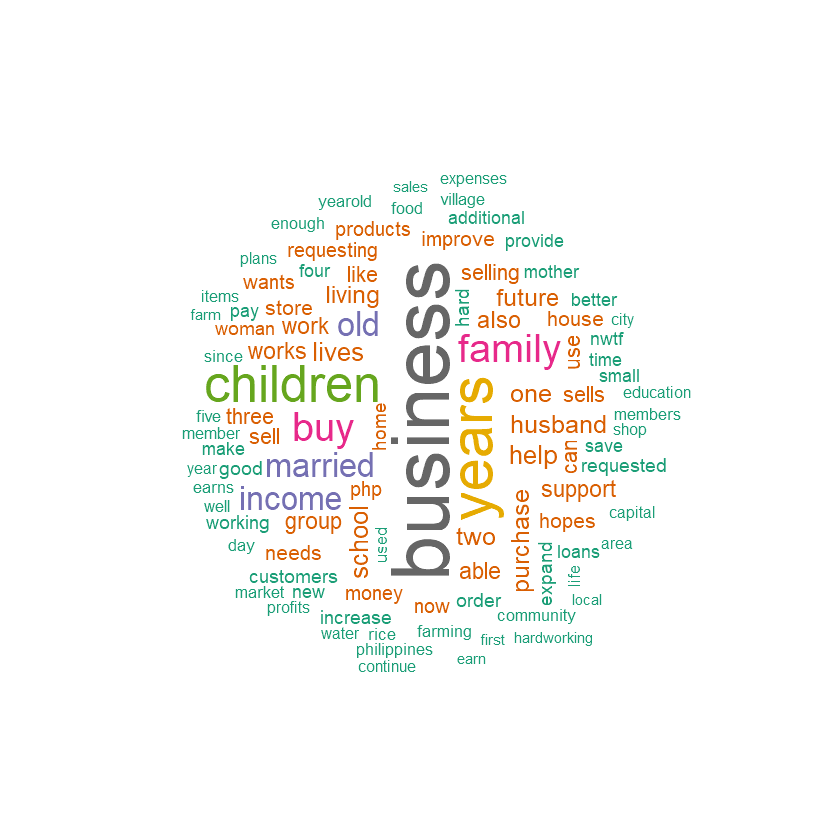

In [22]:
## Simple visualization
wordcloud(corp, max.words = 100, random.order = FALSE,
          colors = brewer.pal(8, "Dark2"))

Next the term-frequency filtered document-term matrix. Obviously this is very similar to the plot above. 

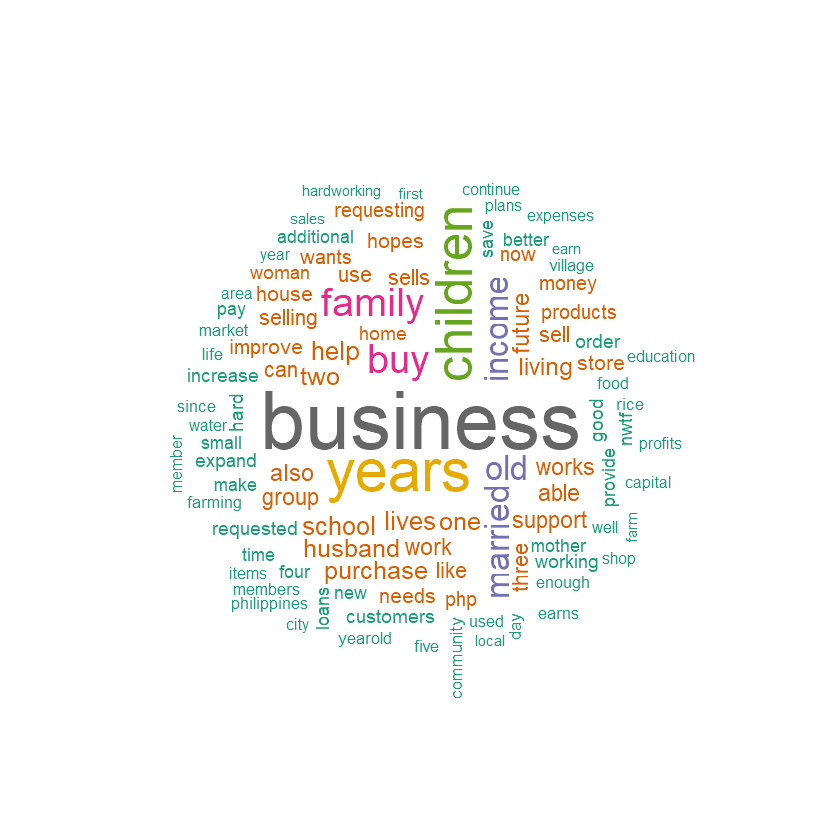

In [23]:
## Counts from dtms
counts <- sort(colSums(as.matrix(dtms)), decreasing = TRUE)
counts <- data.frame(word = names(counts), freq = counts)
wordcloud(words = counts$word, freq = counts$freq,
          max.words = 100, random.order = FALSE,
          colors = brewer.pal(8, "Dark2"))

However, the frequency plot of the tfidf-filtered document-term matrix looks different. There are a lot more terms that disambiguate professions and investment goods.

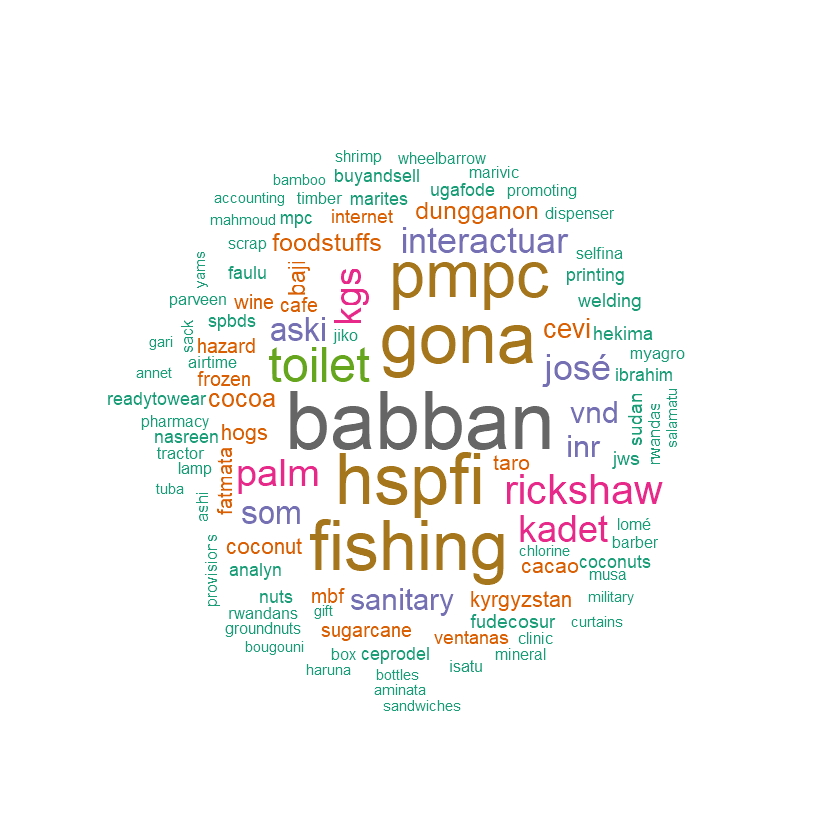

In [24]:
## Counts from dtmw
counts <- sort(colSums(as.matrix(dtmw)), decreasing = TRUE)
counts <- data.frame(word = names(counts), freq = counts)
wordcloud(words = counts$word, freq = counts$freq,
          max.words = 100, random.order = FALSE,
          colors = brewer.pal(8, "Dark2"))

## Dictionary methods: Inferring sentiment

We are using a fixed mapping of terms to infer a sentiment score, and then convert it to discrete sentiment categories. Unsuprisingly, most loan descriptions are phrased to convey a positive message. 

In [25]:
## Dictionary method: Sentiment analysis using dictionaries
sentiment <- analyzeSentiment(dtms, language = "english")
sentiment <- convertToDirection(sentiment$SentimentGI)

## Potentially add back to original data for further analysis
## loans$sentiment <- sentiment

## look at sentiment distribution
table(sentiment)

sentiment
negative  neutral positive 
     139     1000     8861 

## Unsupervised generative model: Topic model

Next we are going to train an unsupervised topic model on the term-frequency filtered document term matrix. You will find that it is hard to find distinct topics, both due to the term filtering, and the fact that most loans are handed out by partner organizations who use a standard questionnaire to get basic information which is then translated to an english description. 

Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
business,business,business,business,children
family,years,years,years,business
income,family,husband,children,old
children,children,children,old,buy
years,married,married,buy,lives
buy,two,work,purchase,one
can,three,help,income,years
save,income,woman,family,support
like,works,works,school,selling
needs,requested,old,group,married


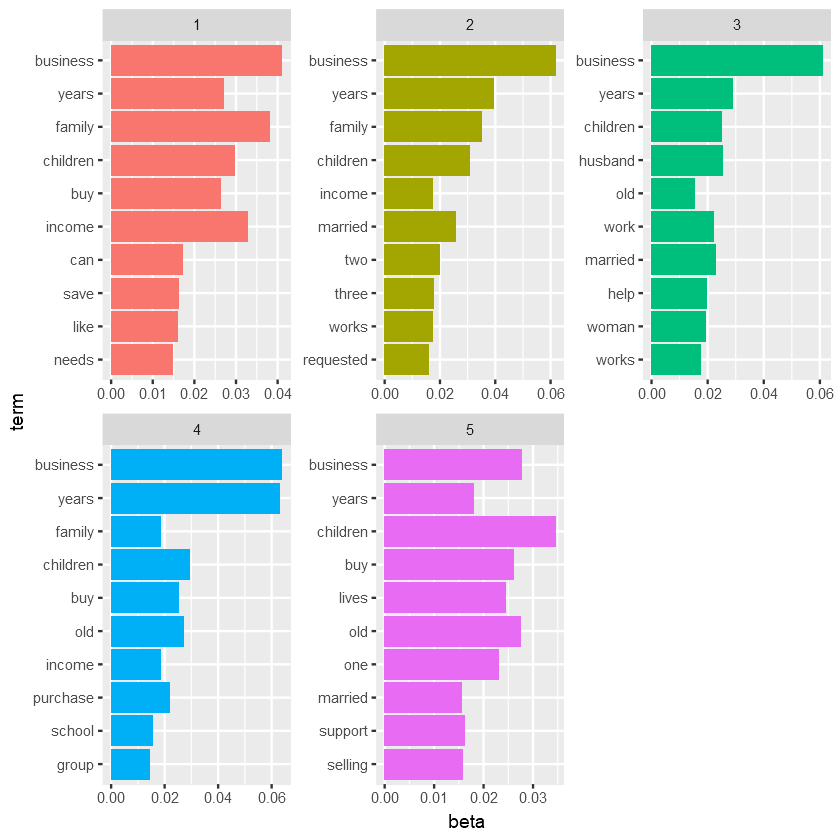

In [26]:
## Unsupervised method: Topic model
lda <- LDA(dtms, k = 5, control = list(seed = 100))
## lda <- LDA(dtmw, k = 5, control = list(seed = 100))

## Most likely topic for each document, could merge this to original data
## topic <- topics(lda, 1)

## Five most frequent terms for each topic
terms(lda, 10)

## Plot most frequent terms and associated probabilities by topic
tpm <- tidy(lda, matrix = "beta")

topterms <-
    tpm %>%
    group_by(topic) %>%
    top_n(10, beta) %>%
    ungroup() %>%
    arrange(topic, -beta)

topterms %>%
    mutate(term = reorder(term, beta)) %>%
    ggplot(aes(term, beta, fill = factor(topic))) +
    geom_col(show.legend = FALSE) +
    facet_wrap(~ topic, scales = "free") +
    coord_flip()

Instead, let us use the `loan use` statement, filtered by tfidf. These topics already look more distinct. You could tweak the filter and the number of topics further to arrive at a more meaningful result.

In [27]:
## not working well due to standardized templates
## let us try to use the `loanuse' statement text for the generative topic model 

# new data
loanuse <- loans[, .(doc_id, loanuse)]
setnames(loanuse, "loanuse", "text")

# new dtm, this time do most of the transformations in one step
dtmuse <- DocumentTermMatrix(Corpus(DataframeSource(loanuse)),
                             control = list(weighting = weightTf,
                                            language = "english",
                                            tolower = TRUE,
                                            removePunctuation = TRUE,
                                            removeNumbers = TRUE,
                                            stopwords = TRUE,
                                            stemming = FALSE,
                                            wordLengths = c(3, Inf)))
inspect(dtmuse)

# Recalculate weights
termtfidf <- tapply(dtmuse$v/row_sums(dtmuse)[dtmuse$i], dtmuse$j, mean) *
    log2(nDocs(dtmuse)/col_sums(dtmuse > 0))
summary(termtfidf)

## Filter by tf-idf
## dim(dtmuse)
dtmuse <- dtmuse[, (termtfidf >= 1.30)]
dtmuse <- dtmuse[row_sums(dtmuse) > 0, ]
dim(dtmuse)

<<DocumentTermMatrix (documents: 10000, terms: 4130)>>
Non-/sparse entries: 57029/41242971
Sparsity           : 100%
Maximal term length: 30
Weighting          : term frequency (tf)
Sample             :
        Terms
Docs     additional business buy pay products purchase rice sell supplies water
  165281          0        0   0   0        1       10    1    0        0     0
  251885          0        0   0   0        0        1    0    0        0     0
  284790          0        0   1   0        0        0    1    0        0     1
  32203           0        0   1   0        0        0    1    0        0     0
  323832          0        0   0   0        1        1    1    0        1     0
  450012          0        1   1   0        2        0    1    0        0     0
  453623          0        0   1   0        0        0    1    0        0     0
  562708          0        0   0   0        0        1    0    0        0     0
  631944          0        0   1   0        1        0    0    

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1829  1.2406  1.6610  1.8666  2.2146 13.2877 

[1] 7684 2984

In [28]:
## Unsupervised method: Topic model, this time for loanuse statement
lda <- LDA(dtmuse, k = 5, control = list(seed = 100))
## str(lda)

In [29]:
## Most likely topic for each document, could merge this to original data
topic <- topics(lda, 1)
head(topic)

269894 1247640  378031  327042 1180737  944550 
      2       4       1       3       2       4

In [30]:
## Five most frequent terms for each topic
terms(lda, 10)

Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
sewing,inventory,merchandise,cow,resell
fabric,capital,resell,merchandise,cattle
piglets,seedlings,hair,livestock,repair
repair,working,livestock,sewing,toilet
dairy,charcoal,farmland,organic,shoes
invest,animals,repair,fabric,invest
toilet,invest,fruits,capital,university
tuition,fruit,charcoal,dairy,feeds
cattle,land,buying,furniture,motorcycle
fishing,shoes,palm,cows,livestock


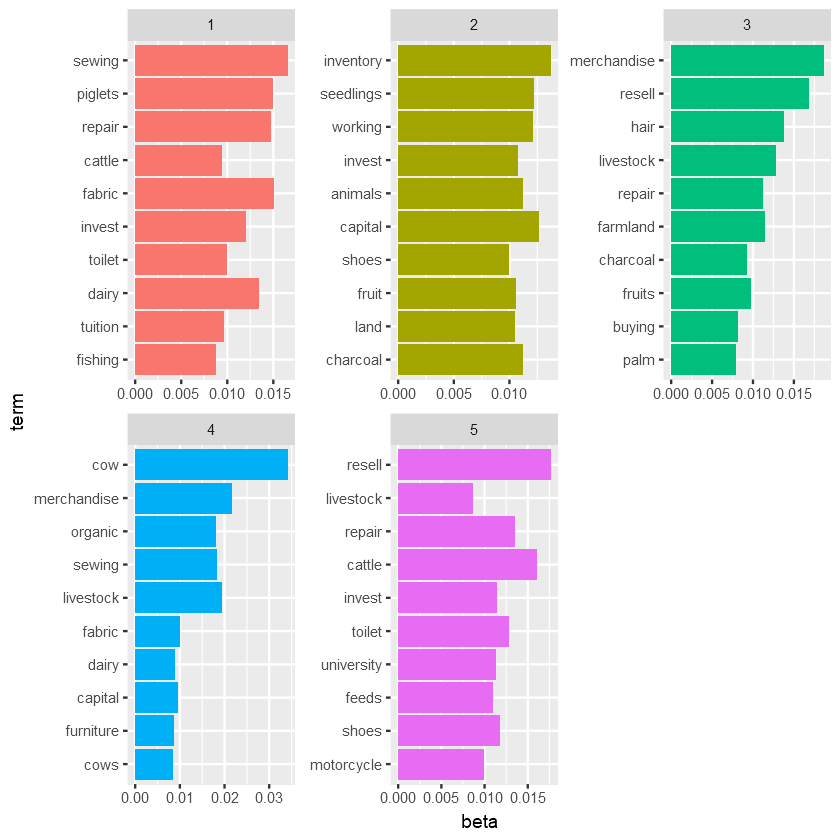

In [31]:
## Plot most frequent terms and associated probabilities by topic
tpm <- tidy(lda, matrix = "beta")

topterms <-
    tpm %>%
    group_by(topic) %>%
    top_n(10, beta) %>%
    ungroup() %>%
    arrange(topic, -beta)

topterms %>%
    mutate(term = reorder(term, beta)) %>%
    ggplot(aes(term, beta, fill = factor(topic))) +
    geom_col(show.legend = FALSE) +
    facet_wrap(~ topic, scales = "free") +
    coord_flip()

Look at unique terms not appearing in other topics.

In [32]:
freqterms <- terms(lda, 40)
duplicates <- c(freqterms)[duplicated(c(freqterms))]
distinctterms <- lapply(as.list(as.data.frame(freqterms)), function(x) x[!(x %in% duplicates)])
distinctterms

$`Topic 1`
[1] "piglets"     "fabrics"     "three"       "goats"       "traditional"
[6] "utensils"   

$`Topic 2`
[1] "calves"    "pig"       "box"       "fuel"      "underwear"

$`Topic 3`
[1] "palm"       "vehicle"    "rent"       "stall"      "repairs"   
[6] "treatment"  "containers" "millet"    

$`Topic 4`
[1] "cow"        "organic"    "furniture"  "another"    "local"     
[6] "husband"    "herbicides"

$`Topic 5`
[1] "tires"      "embroidery" "sodas"      "rickshaw"   "phone"     
[6] "jewelry"    "womens"     "tables"     "nets"

## Supervised methods: Data preparation

The following cells transform and prep the data to be used as inputs for supervised methods. We split the data into a test and a training sample. The outcome we try to predict is whether the loan is obtained for a business proposition in the agricultural sector.

In [35]:
## Supervised methods: Prep data
## Convert the sparse term-document matrix to a standard data frame
bag <- as.data.frame(as.matrix(dtms))
dim(bag)
#bag

[1] 10000   184

In [36]:
## Convert token counts to simple binary indicators
bag.bin <- as.data.frame(sapply(bag, function(x) as.numeric(x > 0)))
dim(bag.bin)
#bag.bin

[1] 10000   184

In [37]:
## Add names to rows
bag$doc_id <- rownames(as.matrix(dtms))
bag.bin$doc_id <- rownames(as.matrix(dtms))

## Add outcomes from the original data: Predict agricultural sector
loans$agsector <- as.numeric(loans$sectorname=="Agriculture")
bag <- merge(bag, loans[, .(agsector, loanamount, doc_id)], by = "doc_id")
bag.bin <- merge(bag.bin, loans[, .(agsector, loanamount, doc_id)], by = "doc_id")
                            
# How many people want a loan in the agricultural sector?                            
table(bag$agsector)


   0    1 
7511 2489 

In [38]:
## Partition data in test and training sample
set.seed(100)
testids <- sample(floor(nrow(bag)/5))
# testids

In [39]:
xtrain <- as.matrix(bag[-testids, !(names(bag) %in% c("agsector", "loanamount", "doc_id"))])
xtest  <- as.matrix(bag[ testids, !(names(bag) %in% c("agsector", "loanamount", "doc_id"))])

xtrain.bin <- as.matrix(bag.bin[-testids, !(names(bag) %in% c("agsector", "loanamount", "doc_id"))])
xtest.bin  <- as.matrix(bag.bin[ testids, !(names(bag) %in% c("agsector", "loanamount", "doc_id"))])

ytrain <- as.factor(bag[-testids,  "agsector"])
ytest  <- as.factor(bag[ testids,  "agsector"])

dim(xtrain)
length(ytrain)

dim(xtest)
length(ytest)

[1] 8000  184

[1] 8000

[1] 2000  184

[1] 2000

## Supervised generative model: Naive Bayes classifier

### With binary token indicators

Naive Bayes is a simple model relying on a conditional independence assumption of the token counts. It often performs acceptable. In this case it does not perform very well, possibly because we filtered the input token data to aggressively. If you redo the analysis with a larger set of features (setting sparsity = 0.95), the naive bayes classifier performs much better. Among other things, there is also no need to remove stopwords here, and it may not improve performance. You can feed the unfiltered data or try different transformations and see whether this improves matters. 

In [40]:
## Supervised generative model: Naive Bayes
## naive_bayes package requires transforming everything to factors and using binary indicators, not counts.
xtrain.factor <- as.data.frame(lapply(as.data.frame(xtrain.bin), as.factor))
xtest.factor <- as.data.frame(lapply(as.data.frame(xtest.bin), as.factor))
nbclassifier <- naive_bayes(xtrain.factor, ytrain, laplace = 1)
nbpred <- predict(nbclassifier, xtest.factor)
# nbclassifier
summary(nbpred)

0    1 
1461  539

In [41]:
## Performance statistics: Classification rate
round(1-mean(as.numeric(nbpred != ytest)), 2)

## Performance statistics: Confusion matrix (
## table(nbpred, ytest)
confusionMatrix(nbpred, ytest)

[1] 0.87

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1327  134
         1  131  408
                                          
               Accuracy : 0.8675          
                 95% CI : (0.8519, 0.8821)
    No Information Rate : 0.729           
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.6641          
                                          
 Mcnemar's Test P-Value : 0.9022          
                                          
            Sensitivity : 0.9102          
            Specificity : 0.7528          
         Pos Pred Value : 0.9083          
         Neg Pred Value : 0.7570          
             Prevalence : 0.7290          
         Detection Rate : 0.6635          
   Detection Prevalence : 0.7305          
      Balanced Accuracy : 0.8315          
                                          
       'Positive' Class : 0               
                        

#### Tuning the laplace smoothing parameter

There isn't really much scope for tuning with naive bayes.

In [42]:
## parameter grid
nb.grid <- expand.grid(
  laplace = seq(0, 1, 0.1),
  adjust = 1,
  usekernel = TRUE
)
nb.grid

laplace,adjust,usekernel
<dbl>,<dbl>,<lgl>
0.0,1,TRUE
0.1,1,TRUE
0.2,1,TRUE
0.3,1,TRUE
0.4,1,TRUE
0.5,1,TRUE
0.6,1,TRUE
0.7,1,TRUE
0.8,1,TRUE


In [43]:
## use k-fold cv to tune the laplace smoothing parameter
nbclassifier <- train(
  xtrain.factor, ytrain,
  method = "naive_bayes",
  trControl = trainControl(method = "cv", number = 10),
  tuneGrid = nb.grid
)

nbclassifier
summary(nbclassifier)

Naive Bayes 

8000 samples
 184 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 7200, 7200, 7200, 7200, 7201, 7201, ... 
Resampling results across tuning parameters:

  laplace  Accuracy   Kappa    
  0.0      0.8760002  0.6632517
  0.1      0.8762502  0.6638032
  0.2      0.8762502  0.6638032
  0.3      0.8762501  0.6636994
  0.4      0.8763751  0.6638637
  0.5      0.8763751  0.6638637
  0.6      0.8765001  0.6642580
  0.7      0.8765001  0.6642580
  0.8      0.8765001  0.6641326
  0.9      0.8765001  0.6641326
  1.0      0.8765001  0.6641326

Tuning parameter 'usekernel' was held constant at a value of TRUE

Tuning parameter 'adjust' was held constant at a value of 1
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were laplace = 0.6, usekernel = TRUE
 and adjust = 1.


================================== Naive Bayes ================================== 
 
- Call: naive_bayes.default(x = x, y = y, laplace = param$laplace, usekernel = TRUE,      adjust = param$adjust) 
- Laplace: 0.6 
- Classes: 2 
- Samples: 8000 
- Features: 184 
- Conditional distributions: 
    - Bernoulli: 184
- Prior probabilities: 
    - 0: 0.7566
    - 1: 0.2434

--------------------------------------------------------------------------------- 


In [44]:
nbpred <- predict(nbclassifier, xtest.factor)
1-mean(as.numeric(nbpred != ytest))
confusionMatrix(nbpred, ytest)

[1] 0.868

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1328  134
         1  130  408
                                          
               Accuracy : 0.868           
                 95% CI : (0.8524, 0.8825)
    No Information Rate : 0.729           
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.6651          
                                          
 Mcnemar's Test P-Value : 0.8535          
                                          
            Sensitivity : 0.9108          
            Specificity : 0.7528          
         Pos Pred Value : 0.9083          
         Neg Pred Value : 0.7584          
             Prevalence : 0.7290          
         Detection Rate : 0.6640          
   Detection Prevalence : 0.7310          
      Balanced Accuracy : 0.8318          
                                          
       'Positive' Class : 0               
                        

### With token counts

Binary features perform only slightly better/worse, mostly just about the same depending on then size of the design matrix. Whether a word occurs at all encodes about the same information compared to how frequent it occurs. 

In [58]:
## fastNaiveBayes is the better package (supports multinomial distribution, for non-binary feature counts)
## fnb.detect_distribution(xtrain)

nbclassifier <- fastNaiveBayes(xtrain, ytrain)
# nbclassifier <- multinomial_naive_bayes(xtrain, ytrain)

nbpred <- predict(nbclassifier, xtest)

In [59]:
## Performance statistics: Classification rate
round(1-mean(as.numeric(nbpred != ytest)), 2)

## Performance statistics: Confusion matrix (
## table(nbpred, ytest)
confusionMatrix(nbpred, ytest)

[1] 0.88

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1338  126
         1  120  416
                                          
               Accuracy : 0.877           
                 95% CI : (0.8618, 0.8911)
    No Information Rate : 0.729           
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.6876          
                                          
 Mcnemar's Test P-Value : 0.7499          
                                          
            Sensitivity : 0.9177          
            Specificity : 0.7675          
         Pos Pred Value : 0.9139          
         Neg Pred Value : 0.7761          
             Prevalence : 0.7290          
         Detection Rate : 0.6690          
   Detection Prevalence : 0.7320          
      Balanced Accuracy : 0.8426          
                                          
       'Positive' Class : 0               
                        

## Supervised text regression: L<sub>1</sub> penalized logistic classifier

Looking at the misclassification rate and the confusion matrix, the model performs better than naive bayes in predicting the agricultural sector. However, looking at precision and recall, the model again does poorly in getting the true condition outcomes right, leading to a large number of false negatives.

### With binary token indicators

In [60]:
## Supervised text regression: L1 penalized logistic regression
l1classifier <- cv.glmnet(xtrain.bin, ytrain, alpha = 1, family = "binomial")
l1pred <- as.factor(predict(l1classifier, xtest.bin, s = "lambda.min", type = "class"))
summary(l1pred)

0    1 
1546  454

In [61]:
## Performance statistics: Classification rate
round(1-mean(as.numeric(l1pred != ytest)), 2)

## Performance statistics: Confusion matrix
caret::confusionMatrix(l1pred, ytest)

[1] 0.89

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1394  152
         1   64  390
                                          
               Accuracy : 0.892           
                 95% CI : (0.8776, 0.9053)
    No Information Rate : 0.729           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.712           
                                          
 Mcnemar's Test P-Value : 3.227e-09       
                                          
            Sensitivity : 0.9561          
            Specificity : 0.7196          
         Pos Pred Value : 0.9017          
         Neg Pred Value : 0.8590          
             Prevalence : 0.7290          
         Detection Rate : 0.6970          
   Detection Prevalence : 0.7730          
      Balanced Accuracy : 0.8378          
                                          
       'Positive' Class : 0               
                        

### With token counts

If you check, the model with feature counts does better than the binary model, but only marginally.

In [68]:
## Supervised text regression: L1 penalized logistic regression
l1classifier <- cv.glmnet(xtrain, ytrain, alpha = 1, family = "binomial")
l1pred <- as.factor(predict(l1classifier, xtest, s = "lambda.min", type = "class"))
summary(l1pred)

0    1 
6444 1556

In [69]:
## Performance statistics: Classification rate
round(1-mean(as.numeric(l1pred != ytest)), 2)

## Performance statistics: Confusion matrix
caret::confusionMatrix(l1pred, ytest)

ERROR: Error in parse(text = x, srcfile = src): <text>:5:61: Unerwartete(s) ')'
4: ## Performance statistics: Confusion matrix
5: caret::confusionMatrix(l1pred, ytrain)                      )
                                                               ^


This also trains a logistic lasso estimator, weighting the penalty factor for each input token by the token's standard deviation. Results do not really differ compared to just standardizing (no surprise).

In [64]:
## L1 logistic classifier using rare feature upweighting
# l1classifier <- cv.glmnet(xtrain, ytrain, alpha = 1, family = "binomial")
## L1 logistic classifier using rare feature upweighting
sdweights <- apply(xtrain, 2, sd)
l1classifier <- cv.glmnet(xtrain, ytrain, alpha = 1, family = "binomial",
                          standardize = FALSE, penalty.factor  = sdweights)
l1pred <- as.factor(predict(l1classifier, xtest, s = "lambda.min", type = "class",
                            penalty.factor  = sdweights))
summary(l1pred)

0    1 
1565  435

In [65]:
## Performance statistics: Classification rate
round(1-mean(as.numeric(l1pred != ytest)), 2)
## Performance statistics: Confusion matrix
caret::confusionMatrix(l1pred, ytest)

[1] 0.89

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1401  164
         1   57  378
                                          
               Accuracy : 0.8895          
                 95% CI : (0.8749, 0.9029)
    No Information Rate : 0.729           
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7018          
                                          
 Mcnemar's Test P-Value : 1.001e-12       
                                          
            Sensitivity : 0.9609          
            Specificity : 0.6974          
         Pos Pred Value : 0.8952          
         Neg Pred Value : 0.8690          
             Prevalence : 0.7290          
         Detection Rate : 0.7005          
   Detection Prevalence : 0.7825          
      Balanced Accuracy : 0.8292          
                                          
       'Positive' Class : 0               
                        

## Remarks and additions

In [ ]:
## How would you go about improving performce for the classifiers?






## (Addendum: Regression example: L<sub>1</sub> penalized linear regression)

In [ ]:
## Further example: Predict Loan Amount
## Supervised text regression: L1 penalized linear regression

## Rebuild outcome vectors
#ytrain <- as.matrix(bag[-testids,  "loanamount"])
#ytest  <- as.matrix(bag[ testids,  "loanamount"])

## Estimate and predict
#l1predictor <- cv.glmnet(xtrain, ytrain, alpha = 1, family = "gaussian")
#l1pred <- predict(l1predictor, xtest, s = "lambda.min", type = "response")

## RMSE
#round(sqrt(mean((l1pred - ytest)^2)), 2)
#postResample(l1pred, ytest)